# SARIMA for Weekly Sales

## Store 1 Dept 3

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('sales_data.csv')

dataset = dataset.loc[(dataset['Dept'] == 3) & (dataset['Store'] == 1)]
dataset['IsHoliday'] = dataset['IsHoliday'].astype(int)

dataset= dataset.set_index(pd.to_datetime(dataset['Date'], dayfirst = True))
dataset.index.freq='W-FRI'
dataset.drop(['Date','Unnamed: 0','Store','IsHoliday','Dept','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Type','Size'],axis=1,inplace = True)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Freq: W-FRI
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Weekly_Sales  143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [4]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

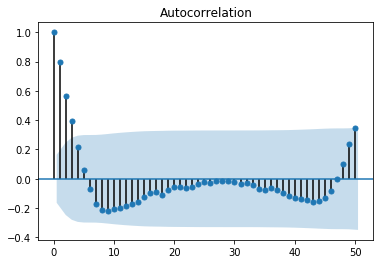

In [5]:
acf=plot_acf(dataset['Weekly_Sales'], lags = 50)

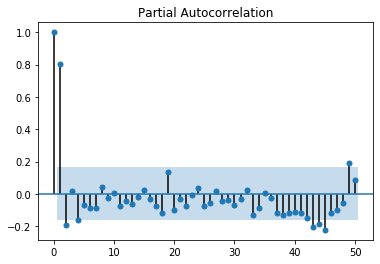

In [6]:
pacf=plot_pacf(dataset['Weekly_Sales'], lags =50)

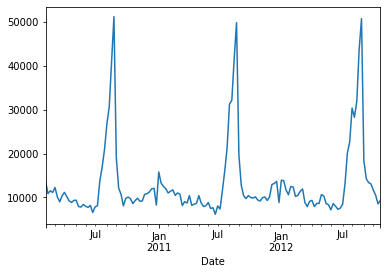

In [7]:
dataset['Weekly_Sales'].plot()

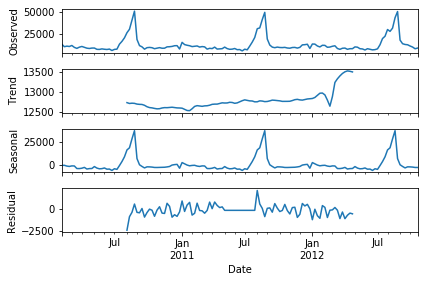

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dataset['Weekly_Sales'], model='additive') #period 52 as it's Weekly data
fig = result.plot()

In [23]:
# Train data is 2010-2011
#Test is 2012
train = dataset.loc[:'2012-01-01']
test = dataset.loc['2012-01-01':]

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")
        
adf_test(dataset['Weekly_Sales'])      

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.506652
p-value                   0.000191
# lags used               1.000000
# observations          141.000000
critical value (1%)      -3.477601
critical value (5%)      -2.882266
critical value (10%)     -2.577822
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [9]:
# m=52 as our data exhibits a trend after every 52 weeks.
from pmdarima import auto_arima
stepwise_model = auto_arima(dataset['Weekly_Sales'], start_p=1, d=1, start_q=1,
                           max_p=1, max_q=1, m=52,
                           start_P=0, seasonal=True,
                           D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True)
print(stepwise_model.summary())

ModuleNotFoundError: No module named 'pmdarima'

SARIMA values are now fitted into the model as shown below:

In [0]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Weekly_Sales'],order=(1,1,1),seasonal_order=(0,1,1,52))
results = model.fit()
results.summary()

/Users/shreya/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -400.460
Date:                            Fri, 10 Apr 2020   AIC                            808.920
Time:                                    13:10:58   BIC                            816.320
Sample:                                02-05-2010   HQIC                           811.705
                                     - 12-30-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2858      0.355      0.805      0.421      -0.410       0.982
ma.L1         -0.7793      0.176     -4.423      0.000      -1.125      -0.434
ma.S.L52      -0.0780      0.089     -0.879      0.380      -0.252       0.096
sigma2      1.436e+06   2.93e+05      4.906      0.000    8.62e+05    2.01e+06
===================================================================================
Ljung-Box (Q):                       26.76   Jarque-Bera (JB):                45.09
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             1.41
Prob(H) (two-sided):                  0.79   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,1)(0,1,1,52) Predictions')

NameError: name 'train' is not defined

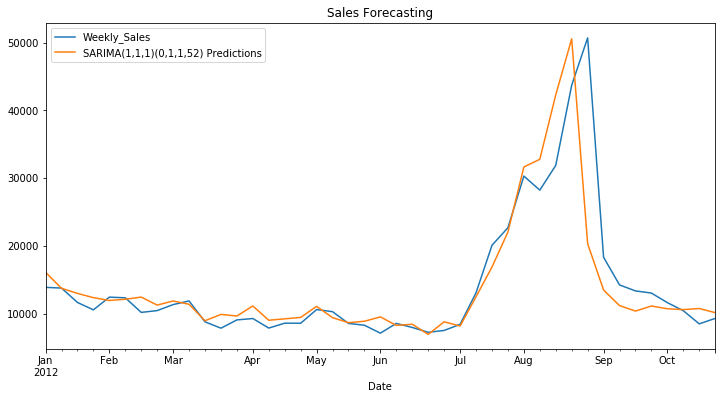

In [0]:
# Plot predictions against known values
title = 'Sales Forecasting'
ylabel='Weekly_Sales'
xlabel='Date'

ax = test['Weekly_Sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)

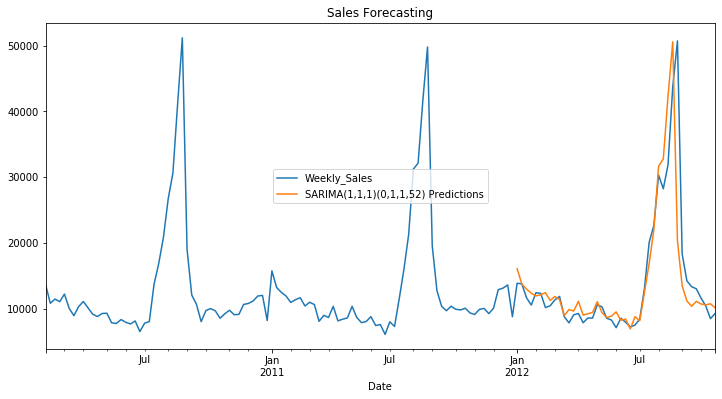

In [0]:
# Plot predictions against known values
title = 'Sales Forecasting'
ylabel='Weekly_Sales'
xlabel='Date'
ax = dataset['Weekly_Sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("Standard deviation of test data: ", np.std(test))
print(mean_absolute_error(test['Weekly_Sales'], predictions))
print(np.sqrt(mean_squared_error(test['Weekly_Sales'],predictions)))

Standard deviation of test data:  Weekly_Sales    9400.961084
dtype: float64
2309.7606655360228
5274.881033958386


We can see that the RMSE is well below the standard devaition and hence we can say the model performed well for this store and department

## Store 1 Dept 8

In [0]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('/Users/shreya/Desktop/sales_data.csv')

dataset = dataset.loc[(dataset['Dept'] == 8) & (dataset['Store'] == 1)]
dataset['IsHoliday'] = dataset['IsHoliday'].astype(int)

dataset= dataset.set_index(pd.to_datetime(dataset['Date'], dayfirst = True))
dataset.index.freq='W-FRI'
dataset.drop(['Date','Unnamed: 0','Store','IsHoliday','Dept','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Type','Size'],axis=1,inplace = True)

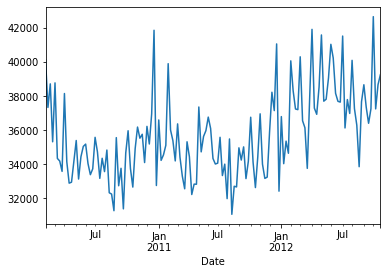

In [0]:
dataset['Weekly_Sales'].plot()

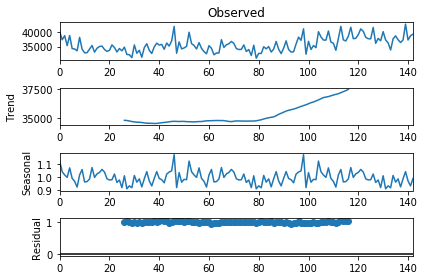

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dataset['Weekly_Sales'].values, model='multiplicative',period=52) #period 52 as it's Weekly data
fig = result.plot()

In [0]:
# Train data is 2010-2011
#Test is 2012
train = dataset.loc[:'2012-01-01']
test = dataset.loc['2012-01-01':]

In [0]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Weekly_Sales'],order=(1,1,1),seasonal_order=(0,1,1,52))
results = model.fit()
results.summary()

/Users/shreya/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -407.192
Date:                            Fri, 10 Apr 2020   AIC                            822.384
Time:                                    13:34:35   BIC                            829.784
Sample:                                02-05-2010   HQIC                           825.168
                                     - 12-30-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8630      0.167     -5.153      0.000      -1.191      -0.535
ma.L1          0.7673      0.164      4.676      0.000       0.446       1.089
ma.S.L52      -0.3107      0.212     -1.463      0.144      -0.727       0.106
sigma2      1.855e+06   4.61e+05      4.024      0.000    9.52e+05    2.76e+06
===================================================================================
Ljung-Box (Q):                       68.14   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.00   Prob(JB):                         0.55
Heteroskedasticity (H):               1.32   Skew:                             0.37
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [0]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,1)(0,1,1,52) Predictions')

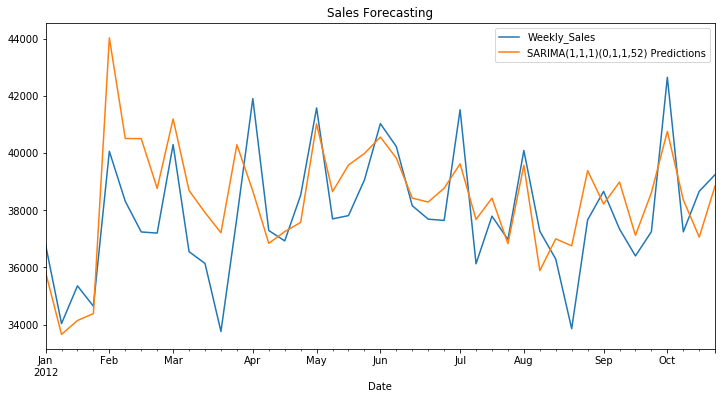

In [0]:
# Plot predictions against known values
title = 'Sales Forecasting'
ylabel='Weekly_Sales'
xlabel='Date'

ax = test['Weekly_Sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)

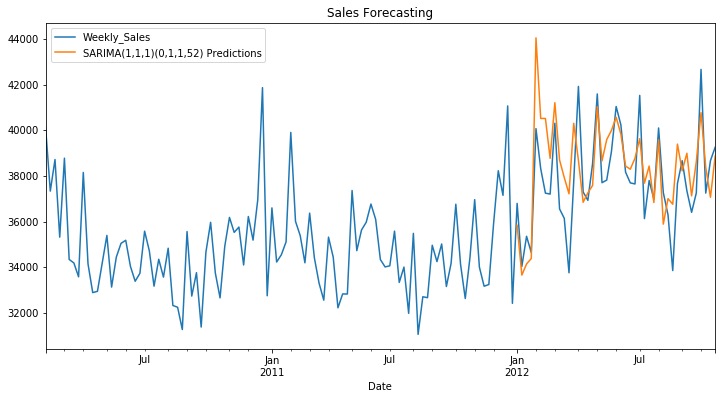

In [0]:
# Plot predictions against known values
title = 'Sales Forecasting'
ylabel='Weekly_Sales'
xlabel='Date'
ax = dataset['Weekly_Sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("Standard deviation of test data: ", np.std(test))
print(mean_absolute_error(test['Weekly_Sales'], predictions))
print(np.sqrt(mean_squared_error(test['Weekly_Sales'],predictions)))

Standard deviation of test data:  Weekly_Sales    2078.042523
dtype: float64
1333.9977586337386
1641.4543025048752


We can see for store 1 Dept 8 the RMSE is less than the standard deviation of the test data but is still pretty close, unlike the prediction for Store 1 Dept 3.